In [54]:
import numpy as np
import torch
from torch import Tensor
from torch import tensor
from torch import nn
from matplotlib import pyplot as plt
import matplotlib as mpl
import torchvision
import json
from mpl_toolkits.mplot3d import Axes3D  # needed for 3d plotting (registers projection)

In [3]:
device = 'cuda'

In [4]:
train_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
train_data_loader = torch.utils.data.DataLoader(train_data,batch_size=16)

In [5]:
class MnistClassifier(nn.Module):
    def __init__(self,in_channels,out_features,device = 'cuda',dtype= float):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=32,kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6,out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600,out_features=120)
        self.fc3 = nn.Linear(in_features=120,out_features=10)
    def forward(self,x:torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    def sample_loss_landscape(self, dataloader, criterion, d1: torch.Tensor, d2: torch.Tensor,
                            space=torch.linspace(-1, 1, 50), device='cuda', max_samples=10):
        self.eval()
        original_params = torch.nn.utils.parameters_to_vector(self.parameters()).detach().to(device)
        losses = torch.zeros(len(space), len(space), device=device)

        with torch.no_grad():
            for i, alpha in enumerate(space):
                for j, beta in enumerate(space):
                    # New params = original + alpha * d1 + beta * d2
                    new_params = original_params + alpha * d1.to(device) + beta * d2.to(device)
                    torch.nn.utils.vector_to_parameters(new_params, self.parameters())

                    total_loss = 0
                    total_samples = 0

                    for inputs, targets in dataloader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = self(inputs)
                        loss = criterion(outputs, targets)
                        batch_size = inputs.size(0)

                        total_loss += loss.item() * batch_size
                        total_samples += batch_size

                        if total_samples >= max_samples:
                            break

                    losses[i, j] = total_loss / total_samples

        torch.nn.utils.vector_to_parameters(original_params, self.parameters())
        self.train()
        return losses.cpu()



In [9]:
def save_numpy(fname, data):
    np.save(fname, data)

In [10]:
model = MnistClassifier(1,10).to(device=device)
optimizer = torch.optim.Adam(model.parameters())

plot loss and regrets of optimizers

In [29]:
def accuracy_test(model: nn.Module, test_data):
    correct = 0
    total = len(test_data)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=1)
    model.to('cpu')
    for img, label in test_loader:
        pred = model(img).argmax().item()
        if(pred == label):
            correct+=1
    model.to(device=device)
    return correct/total
def train(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, epochs=2, seed=123) -> tuple:
    loss_history = []
    cumulative_regrets = []
    instantaneous_regrets = []
    accuracy_history = []
    best_loss = float('inf')
    cumulative_regret = 0.0
    loss_fn = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for img, label in dataloader:
            img = img.to(dtype=torch.float32, device=device)
            label = torch.nn.functional.one_hot(label, num_classes=10).to(dtype=torch.float32, device=device)

            pred = model(img)
            optimizer.zero_grad()
            loss = loss_fn(pred, label)
            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            loss_history.append(current_loss)

            # Regret calculations
            if current_loss < best_loss:
                best_loss = current_loss
            instant_regret = current_loss - best_loss
            instantaneous_regrets.append(instant_regret)

            cumulative_regret += instant_regret
            cumulative_regrets.append(cumulative_regret)
        accuracy = accuracy_test(model=model, test_data=test_data)
        accuracy_history.append(accuracy)

    print("done")
    return loss_history, instantaneous_regrets,accuracy_history


In [16]:
# Define a function to create a new model
def new_model():
    torch.manual_seed(123)
    return MnistClassifier(in_channels=1, out_features=10).to(device)


In [27]:
epochs = 10

In [50]:
# Adam
model_adam = new_model()
adam = torch.optim.AdamW(model_adam.parameters())
adam_loss, adam_regrets,adam_accuracy_history = train(model=model_adam, dataloader=train_data_loader, optimizer=adam,epochs=epochs)

c:\Users\minhh\Downloads\Projects\sundayai\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


done


In [31]:
# SGD
model_sgd = new_model()
sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01)
sgd_loss, sgd_regrets, sgd_accuracy_history = train(model=model_sgd, dataloader=train_data_loader, optimizer=sgd, epochs=epochs)

done


In [32]:
# RMSProp
model_rmsprop = new_model()
rmsprop = torch.optim.RMSprop(model_rmsprop.parameters(), lr=0.001)
rmsprop_loss, rmsprop_regrets, rmsprop_accuracy_history = train(model=model_rmsprop, dataloader=train_data_loader, optimizer=rmsprop, epochs=epochs)

done


In [33]:
# Adagrad
model_adagrad = new_model()
adagrad = torch.optim.Adagrad(model_adagrad.parameters(), lr=0.01)
adagrad_loss, adagrad_regrets, adagrad_accuracy_history = train(model=model_adagrad, dataloader=train_data_loader, optimizer=adagrad, epochs=epochs)

done


In [34]:
print(adam_loss)
print(sgd_loss)
print(rmsprop_loss)
print(adagrad_loss)

[2.465284824371338, 5.81450080871582, 4.112165927886963, 3.080888271331787, 4.407798767089844, 1.1421358585357666, 2.1180717945098877, 2.014617919921875, 0.9997048377990723, 0.8915787935256958, 1.6066511869430542, 1.877255916595459, 2.2449498176574707, 2.1123080253601074, 1.7916414737701416, 2.460268497467041, 1.5575510263442993, 0.8382468223571777, 1.9689106941223145, 3.088690757751465, 1.7592885494232178, 1.8232868909835815, 0.8765467405319214, 0.9546061754226685, 1.3777403831481934, 1.6075870990753174, 1.4335365295410156, 0.7978225946426392, 0.6912142634391785, 1.0369263887405396, 1.593883991241455, 2.3889238834381104, 1.268819808959961, 0.7646604180335999, 0.9409801363945007, 1.3834269046783447, 0.9219334721565247, 1.2043524980545044, 1.1618916988372803, 0.9738457798957825, 0.7977487444877625, 0.7062057256698608, 0.7281116247177124, 1.4306870698928833, 1.0110602378845215, 0.19625046849250793, 0.7373489141464233, 1.1109459400177002, 1.064448356628418, 0.8785002827644348, 0.508641362

In [109]:
np.save("adam_loss.npy", np.array(adam_loss))
np.save("sgd_loss.npy", np.array(sgd_loss))
np.save("rmsprop_loss.npy", np.array(rmsprop_loss))
np.save("adagrad_loss.npy", np.array(adagrad_loss))

plot loss

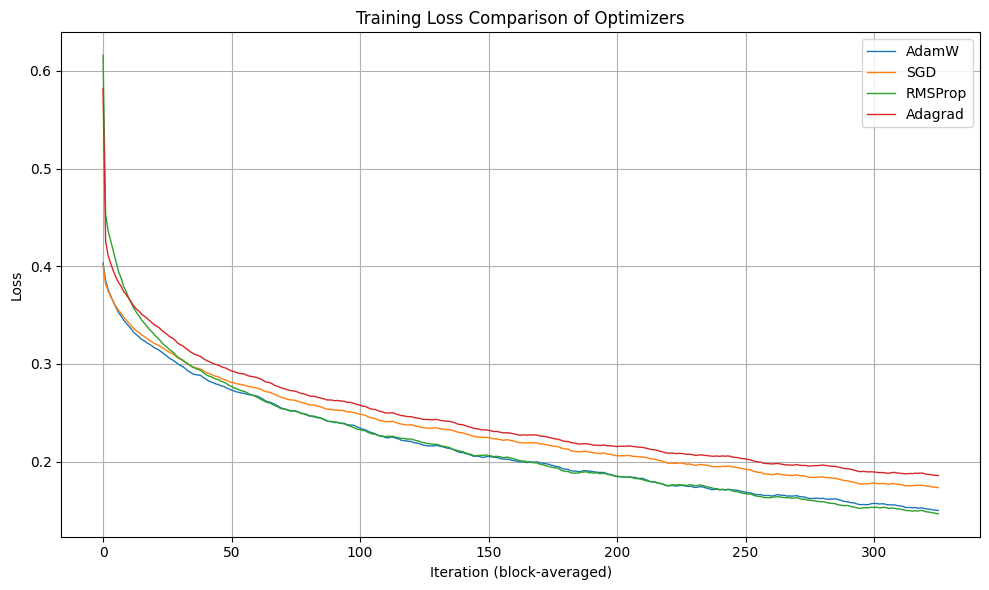

In [51]:
def moving_average(data, window_size=1):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
def block_average(data, block_size):
    data = np.array(data)
    num_blocks = len(data) // block_size
    data = data[:num_blocks * block_size]  # Trim to fit
    return data.reshape(num_blocks, block_size).mean(axis=1)

step = 100  # sample every 100 iterations
window = 50  # smoothing window size

plt.figure(figsize=(10, 6))

plt.plot(moving_average(block_average(adam_loss, step), window), label='AdamW', linewidth=1)
plt.plot(moving_average(block_average(sgd_loss, step), window), label='SGD', linewidth=1)
plt.plot(moving_average(block_average(rmsprop_loss, step), window), label='RMSProp', linewidth=1)
plt.plot(moving_average(block_average(adagrad_loss, step), window), label='Adagrad', linewidth=1)

plt.title("Training Loss Comparison of Optimizers")
plt.xlabel("Iteration (block-averaged)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plot accuracy

accuracy before train(same seed -> same random parameter)

In [42]:
torch.manual_seed(123)
base_accuracy = accuracy_test(new_model(),test_data=test_data)
base_accuracy

c:\Users\minhh\Downloads\Projects\sundayai\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.0725

plot

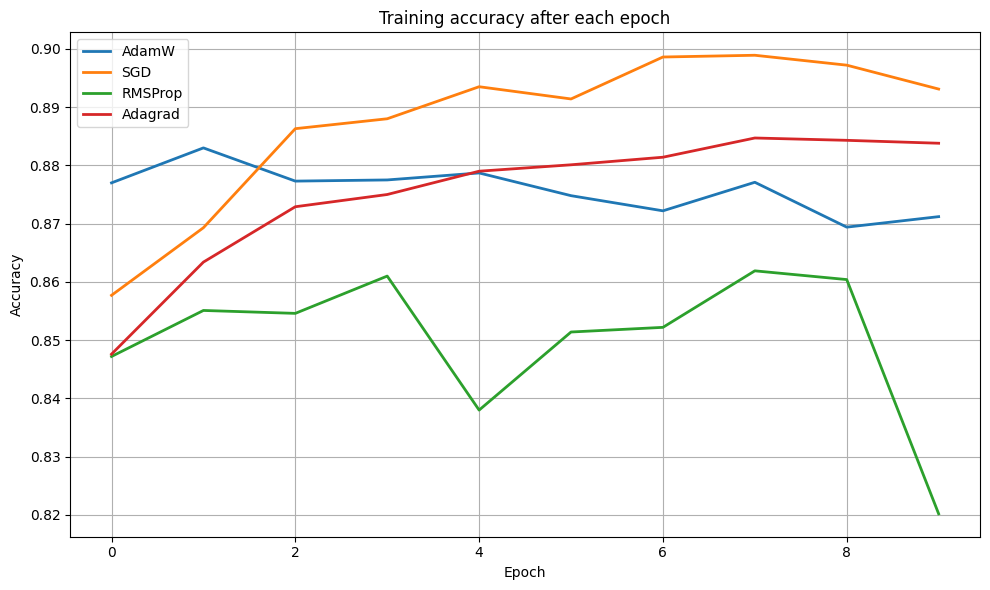

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(adam_accuracy_history, label='AdamW', linewidth=2)
plt.plot(sgd_accuracy_history, label='SGD', linewidth=2)
plt.plot(rmsprop_accuracy_history, label='RMSProp', linewidth=2)
plt.plot(adagrad_accuracy_history, label='Adagrad', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.title('Training accuracy after each epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
print(adam_accuracy_history)
print(sgd_accuracy_history)

[0.8776, 0.8829, 0.8825, 0.8793, 0.8727, 0.869, 0.8587, 0.8575, 0.8507, 0.8605]
[0.8577, 0.8693, 0.8863, 0.888, 0.8935, 0.8914, 0.8986, 0.8989, 0.8972, 0.8931]


plot regrets

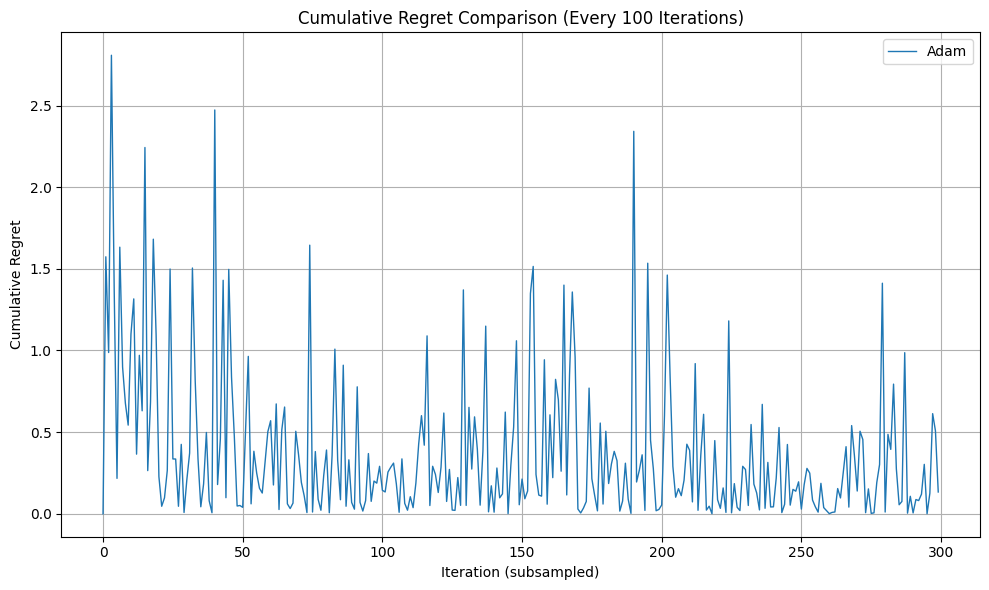

In [ ]:
step = 100  # Subsample for clarity

plt.figure(figsize=(10, 6))

plt.plot(adam_regrets[::step], label='Adam', linewidth=1)
plt.plot(sgd_regrets[::step], label='SGD', linewidth=1)
plt.plot(np.array(rmsprop_regrets[::step]), label='RMSProp', linewidth=1)
plt.plot(np.array(adagrad_regrets[::step]), label='Adagrad', linewidth=1)

plt.title(f"Cumulative Regret Comparison (Every {step} Iterations)")
plt.xlabel("Iteration (subsampled)")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()